In [ ]:

!pip install kaggle

In [ ]:
#upload the credentials of the kaggle account
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sandeepvy","key":"3d4c4bd83760764c26e7a3b39022c523"}'}

In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:

!kaggle competitions download -c galaxy-zoo-the-galaxy-challenge

100% 1.00G/1.01G [00:21<00:00, 80.7MB/s]
100% 1.01G/1.01G [00:21<00:00, 49.7MB/s]
  0% 0.00/520k [00:00<?, ?B/s]
100% 520k/520k [00:00<00:00, 72.5MB/s]
 98% 777M/792M [00:16<00:00, 45.2MB/s]
100% 792M/792M [00:16<00:00, 49.2MB/s]
  0% 0.00/265k [00:00<?, ?B/s]
100% 265k/265k [00:00<00:00, 17.5MB/s]
100% 4.63M/4.63M [00:00<00:00, 6.25MB/s]

  0% 0.00/265k [00:00<?, ?B/s]
100% 265k/265k [00:00<00:00, 80.0MB/s]


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, random, shutil
import tensorflow as tf
import seaborn
from tensorflow import keras
from tensorflow.keras import preprocessing, layers
from tensorflow.keras.callbacks import EarlyStopping
from keras_preprocessing import image

In [ ]:
!unzip /content/images_training_rev1.zip

Streaming output truncated to the last 5000 lines.
  inflating: images_training_rev1/926425.jpg  
  inflating: images_training_rev1/926426.jpg  
  inflating: images_training_rev1/926435.jpg  
  inflating: images_training_rev1/926446.jpg  
  inflating: images_training_rev1/926448.jpg  
  inflating: images_training_rev1/926453.jpg  
  inflating: images_training_rev1/926462.jpg  
  inflating: images_training_rev1/926478.jpg  
  inflating: images_training_rev1/926480.jpg  
  inflating: images_training_rev1/926484.jpg  
  inflating: images_training_rev1/926488.jpg  
  inflating: images_training_rev1/926509.jpg  
  inflating: images_training_rev1/926522.jpg  
  inflating: images_training_rev1/926544.jpg  
  inflating: images_training_rev1/926547.jpg  
  inflating: images_training_rev1/926548.jpg  
  inflating: images_training_rev1/926551.jpg  
  inflating: images_training_rev1/926602.jpg  
  inflating: images_training_rev1/926630.jpg  
  inflating: images_training_rev1/926649.jpg  
  inflati

In [ ]:
#Set the base paths
base_path = '/content/galaxy-zoo/'
training_solutions = os.path.join(base_path, 'training_solutions_rev1.zip')
training_images    = os.path.join(base_path, 'images_training_rev1')

In [ ]:
df = pd.read_csv(training_solutions, compression="zip")
cols = df.columns
new = list(map(lambda s: s.replace('Class','Q'), cols))
df.columns = new
df.head()

,GalaxyID,Q1.1,Q1.2,Q1.3,Q2.1,Q2.2,Q3.1,Q3.2,Q4.1,Q4.2,Q5.1,Q5.2,Q5.3,Q5.4,Q6.1,Q6.2,Q7.1,Q7.2,Q7.3,Q8.1,Q8.2,Q8.3,Q8.4,Q8.5,Q8.6,Q8.7,Q9.1,Q9.2,Q9.3,Q10.1,Q10.2,Q10.3,Q11.1,Q11.2,Q11.3,Q11.4,Q11.5,Q11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027226,0.000000,0.027226,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.000000,0.0,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.0,0.000000,0.096119,0.096119,0.000000,0.128159,0.0,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029383,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [ ]:
ellipticals = df[(df['Q1.1']>0.7) & (df['Q7.1']>0.4)]['GalaxyID'].tolist()

lenticulars = df[(df['Q1.1']>0.7) & (df['Q7.2']>0.4)]['GalaxyID'].tolist()

spirals = df[(df['Q1.2']>0.7) & (df['Q2.1']>0.4)]['GalaxyID'].tolist()

print('Total number of elliptical examples: ',  len(ellipticals))
print('Total number of lenticular examples: ',  len(lenticulars))
print('Total number of spiral examples: ',  len(spirals))

Total number of elliptical examples:  7311
Total number of lenticular examples:  6625
Total number of spiral examples:  4635


In [ ]:
def _proc_images(src, dst, label, arr, percent):
    train_dir = os.path.join(dst, 'train')
    val_dir = os.path.join(dst, 'validation')
    
    train_dest = os.path.join(train_dir, label)
    val_dest   = os.path.join(val_dir, label)
    
    if not os.path.exists(train_dest):
        os.makedirs(train_dest)

    if not os.path.exists(val_dest):
        os.makedirs(val_dest)
    
    random.shuffle(arr)
    
    idx = int(len(arr)*percent)
    for i in arr[0:idx]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(train_dest, str(i)+'.jpg'))
    for i in arr[idx:idx+1000]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(val_dest, str(i)+'.jpg'))
    
    print(label, 'done!')
    
    

In [ ]:
my_data="/content/galaxy-zoo-clean/data/"

In [ ]:
_proc_images(training_images, '/content/galaxy-zoo-clean/data/', 'elliptical', ellipticals, 0.50)
_proc_images(training_images,'/content/galaxy-zoo-clean/data/', 'lenticular', lenticulars, 0.56)
_proc_images(training_images, '/content/galaxy-zoo-clean/data/', 'spiral', spirals, 0.77)


elliptical done!
lenticular done!
spiral done!


In [ ]:
print('Total train Elliptical:', len(os.listdir(os.path.join(my_data, 'train', 'elliptical'))))
print('Total train lenticular:', len(os.listdir(os.path.join(my_data, 'train', 'lenticular'))))
print('Total train spiral:', len(os.listdir(os.path.join(my_data, 'train', 'spiral'))))


print('Total validation elliptical:', len(os.listdir(os.path.join(my_data, 'validation', 'elliptical'))))
print('Total validation lenticular:', len(os.listdir(os.path.join(my_data, 'validation', 'lenticular'))))
print('Total validation spiral:', len(os.listdir(os.path.join(my_data, 'validation', 'spiral'))))

Total train Elliptical: 3655
Total train lenticular: 3710
Total train spiral: 3568
Total validation elliptical: 1000
Total validation lenticular: 1000
Total validation spiral: 1000


ELLIPTICAL


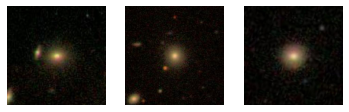

In [ ]:
for num, file in enumerate(os.listdir('/content/galaxy-zoo-clean/data/train/elliptical')[0:3]):
    img = image.load_img(os.path.join(my_data, 'train', 'elliptical', file) , target_size=(227, 227))
    plt.subplot(1, 3, num+1)
    plt.axis('off')
    plt.imshow(img)
print("ELLIPTICAL")

LENTICULAR


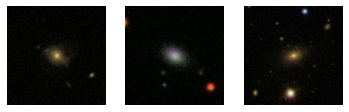

In [ ]:
for num, file in enumerate(os.listdir('/content/galaxy-zoo-clean/data/train/lenticular')[0:3]):
    img = image.load_img(os.path.join(my_data, 'train', 'lenticular', file) , target_size=(227, 227))
    plt.subplot(1, 3, num+1)
    plt.axis('off')
    plt.imshow(img)
print("LENTICULAR")

SPIRAL


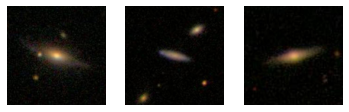

In [ ]:
for num, file in enumerate(os.listdir('/content/galaxy-zoo-clean/data/train/spiral')[0:3]):
    img = image.load_img(os.path.join(my_data, 'train', 'spiral', file) , target_size=(227, 227))
    plt.subplot(1, 3, num+1)
    plt.axis('off')
    plt.imshow(img)
print("SPIRAL")

In [ ]:
train_dir = '/content/galaxy-zoo-clean/data/train'
validation_dir = '/content/galaxy-zoo-clean/data/validation'

In [ ]:
total_train = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_train += len(os.listdir(os.path.join(train_dir, c)))
print('Total train:', total_train)

total_validation = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_validation += len(os.listdir(os.path.join(validation_dir, c)))
print('Total validation:', total_validation)

Total train: 10933
Total validation: 3000


In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1.0/255,
                    )
validation_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(227,227),
                                                    batch_size=128,
                                                    shuffle=True,
                                                    class_mode='categorical')
validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                         target_size=(227,227),
                                                         batch_size=64,
                                                         shuffle=True,
                                                         class_mode='categorical')


Found 10933 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
image_shape=(227,227,3)


In [ ]:

model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(64, (3,3),activation='relu', padding='valid', input_shape=image_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),

    tf.keras.layers.Conv2D(64, (3,3),activation='relu', padding='valid'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
    
    tf.keras.layers.Conv2D(64, (3,3),activation='relu', padding='valid'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),

    tf.keras.layers.Conv2D(64, (3,3),activation='relu', padding='valid'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
    

    # flatten the image pixels
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(2048, input_shape=(227*227*3,), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dropout(0.5),

    # 3 neuron fully connected hidden layer
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 225, 225, 64)      1792      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 110, 110, 64)      36928     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 23, 23, 64)       

In [ ]:
from keras.callbacks import EarlyStopping
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='auto')

In [ ]:
model.compile(  loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
%time
history=model.fit(train_generator, batch_size=64, epochs=30, validation_data=validation_generator, verbose=1, 
                  callbacks=[earlystopper])

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 34.1 µs
Epoch 1/30
86/86 [==============================] - 1602s 19s/step - loss: 0.9469 - accuracy: 0.4859 - val_loss: 0.5798 - val_accuracy: 0.6877
Epoch 2/30
86/86 [==============================] - 1576s 18s/step - loss: 0.5551 - accuracy: 0.7100 - val_loss: 0.4932 - val_accuracy: 0.7437
Epoch 3/30
86/86 [==============================] - 1574s 18s/step - loss: 0.4770 - accuracy: 0.7615 - val_loss: 0.4153 - val_accuracy: 0.7960
Epoch 4/30
86/86 [==============================] - 1586s 18s/step - loss: 0.4190 - accuracy: 0.8012 - val_loss: 0.3703 - val_accuracy: 0.8350
Epoch 5/30
86/86 [==============================] - 1565s 18s/step - loss: 0.3772 - accuracy: 0.8317 - val_loss: 0.3606 - val_accuracy: 0.8387
Epoch 6/30
86/86 [==============================] - 1566s 18s/step - loss: 0.3345 - accuracy: 0.8537 - val_loss: 0.2999 - val_accuracy: 0.8697
Epoch 7/30
86/86 [==============================] - 1565s 18s/step - loss: 0.2

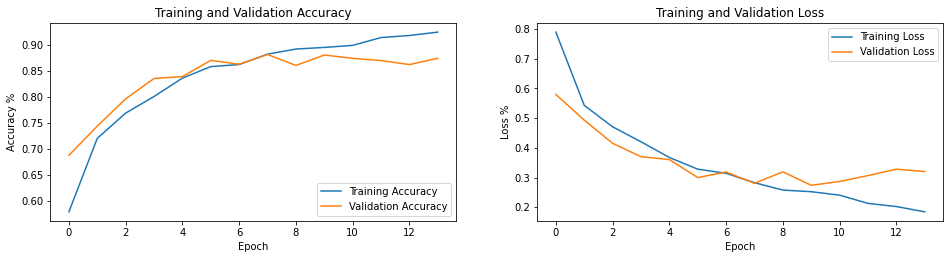

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # range for the number of epochs

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss %')
plt.title('Training and Validation Loss')
plt.savefig('./plots-v2.png')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.789717,0.579347,0.579790,0.687667,0
1,0.543123,0.720205,0.493247,0.743667,1
2,0.470761,0.768591,0.415257,0.796000,2
3,0.420430,0.800421,0.370275,0.835000,3
4,0.367573,0.835727,0.360552,0.838667,4
5,0.328170,0.857770,0.299906,0.869667,5
6,0.314334,0.861703,0.318687,0.862333,6
7,0.282652,0.881643,0.280682,0.881000,7
8,0.257800,0.891430,0.319188,0.860000,8
9,0.252357,0.894539,0.273902,0.880000,9


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [ ]:
model.save_weights('Custom_cnn_classify.h5')